# YOLOv8 demo - custom model

In [ ]:
# Install YOLOv8
%pip install ultralytics
%pip install opencv-python

In [2]:
# Import YOLOv8
from ultralytics import YOLO

# Import image visualization
import cv2

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Move data to datasets folder that YOLOv8 expects
!rm -rf ./ai-demos
!git clone https://github.com/tkubica12/ai-demos
!mv -f ./ai-demos/yolo/datasets .

In [11]:
# Set parameters
epochs = 100

## Transfer learning
Here we will take pretrained weights as starting point and continue training with our own dataset. We have just very few examples to train on yet due to tranfer learning we good results fairly quickly (with a just a few iterations = cheaply).

Best for similar cases of new objects in similar general context.

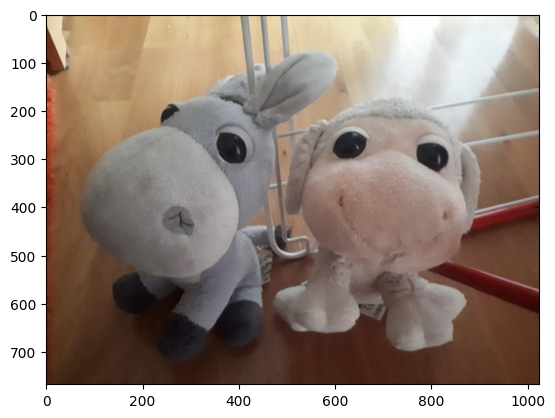

In [4]:
# Show one image from dataset
%matplotlib inline
from matplotlib import pyplot as plt
img = cv2.imread("./datasets/train/images/20181209_093257_jpg.rf.9e5de39c501d75369ffa14627baaa318.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [31]:
# Load pretrained weights
model = YOLO('yolov8n.pt')

In [ ]:
# Train the model
train = model.train(data='./datasets/data.yaml', epochs=1000, imgsz=1024)

In [33]:
# Find folder with latest run of training
import os

files = os.listdir("runs/detect/")
max_number = 0
latest_run = ""
for file in files:
    if file.split("train")[1]:
        number = int(file.split("train")[1])
        max_number = max(max_number, number)
if max_number == 0:
    latest_run = "runs/detect/train"
else:
    latest_run = "runs/detect/train" + str(max_number)
print(latest_run)

runs/detect/train14



image 1/1 /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100/code/datasets/test/20181209_092837.jpg: 768x1024 1 oslik, 1 ovecka, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


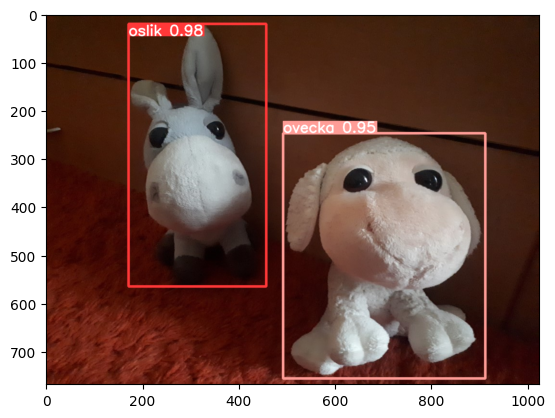

In [44]:
# Test sample 1
best_model = YOLO(f"{latest_run}/weights/best.pt")
results = best_model("./datasets/test/20181209_092837.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))


image 1/1 /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100/code/test2017/000000284881.jpg: 768x1024 (no detections), 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)


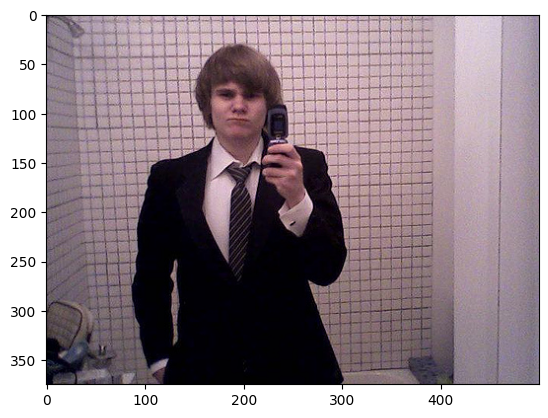

In [45]:
# Generic picture - we expect no objects to be found
results = best_model("./test2017/000000284881.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

## Fresh model from few data
Here we will use YOLOv8 with no pretraining and train on our very very small dataset. Can workout well for our extremly simple example, but in practice big high quality dataset will be needed to get good results.

Best for highly specialised visual tasks where transfer learning will not help, eg. medical images.

In [46]:
# Load empty model
model = YOLO('yolov8n.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
# Train the model
train = model.train(data='./datasets/data.yaml', epochs=1000, patience=0, imgsz=1024)

In [1]:
# Find folder with latest run of training
import os

files = os.listdir("runs/detect/")
max_number = 0
latest_run = ""
for file in files:
    if file.split("train")[1]:
        number = int(file.split("train")[1])
        max_number = max(max_number, number)
if max_number == 0:
    latest_run = "runs/detect/train"
else:
    latest_run = "runs/detect/train" + str(max_number)
print(latest_run)

runs/detect/train16



image 1/1 /mnt/batch/tasks/shared/LS_root/mounts/clusters/a100/code/datasets/test/20181209_092837.jpg: 768x1024 1 oslik, 1 ovecka, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


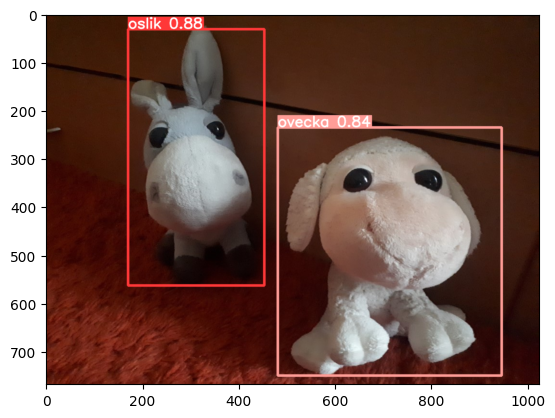

In [5]:
# Test sample 1
best_model = YOLO(f"{latest_run}/weights/best.pt")
results = best_model("./datasets/test/20181209_092837.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

In [ ]:
# Generic picture
results = best_model("./test2017/000000284881.jpg") 
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))